In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import cmath
import warnings
from enum import Enum
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, confusion_matrix
from collections import Counter
warnings.filterwarnings("ignore")

In [2]:
class Compression_Method(Enum):
    XY = 1               #applies PCA on X and Y then filters (1)
    AmpPhase = 2         #applies PCA on Amplitude and Phase then filters (2)
    AmpPhaseFiltered = 3 #applies PCA on Amplitude and Phase after filtering (3)

#Modify this to change the approach used: XY, AmpPhase, AmpPhaseFiltered
method = Compression_Method.AmpPhase
scaler = StandardScaler()
ignorePhases = True
saveCSV = True

base_directory = 'csv/results'
os.makedirs(base_directory, exist_ok=True)

#### Variables and Functions definitions

In [3]:
notInterestedIndexes = list(range(-32,-28)) + list(range(0,1)) + list(range(29,32)) #null columns in the dataset
interestedIndexes = list(range(-28,0)) + list(range(1,29)) #non null columns in the dataset

w1=5 #for filtering
w2=3 #for windows
lambda1=3 #threshold

#build ground truth
t2 = 1205
lb1 = [120,360,600,900]
ub1 = [240,480,720,1080]
lb2 = [t2+l for l in [180,540,990,1500]]
ub2 = [t2+u for u in [360,750,1170,1590]]

lower_bounds = lb1+lb2
upper_bounds = ub1+ub2

In [4]:
def getGT(timestamp,lower_bounds,upper_bounds):
    # if I'm in the room in one case, or I'm crossing the entrance put 1
    for i in range (0, len(lower_bounds)):
        if (timestamp >= lower_bounds[i]) & (timestamp <= upper_bounds[i]):
            return 1
    return 0

def classify_presence(df,ycol="MuStdAmplPaper",gt="Label",plot_roc=False,num_iter=1000):
    # Y are the labels that indicate if i'm passing or not
    Y = df[gt]
    # thr is the threshold: if amplitude > thr, then assign to Y_pred 1 (presence), otherwise 0. Every time update the threshold
    thr= df[ycol].min()
    tpr = []
    fpr= []
    thr_list= []
    step = (df[ycol].max() - df[ycol].min()) / num_iter
    while thr <= df[ycol].max():
        # compute the predictions
        Y_pred = df.apply(lambda row: 1 if row[ycol] >= thr else 0, axis=1)
        tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
        # compute True Positive Rate and False Positive rate to plot the roc curve
        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))
        thr_list.append(thr)
        thr += step
    
    if plot_roc:
        plt.figure(figsize=(3,3),dpi=220)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], color = 'green')
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.grid()
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve")
        plt.show()
    auc_score = auc(fpr,tpr)    
    
    return auc_score

def extractWindowedFeatures(data, column_indexes = [], w2=3):
    data["TimeWindow"] = np.floor(data["Timestamp"] / w2)*w2
    #vertical mean/std
    dataStd = data.groupby(by="TimeWindow").std().drop(["Timestamp","Frame_num"],axis=1)
    #dataMean = data.groupby(by="TimeWindow").mean().drop(["Timestamp","Frame_num"],axis=1)
    
    featuredDf = pd.DataFrame()
    featuredDf["Time"] = data["TimeWindow"].unique()
    #horizontal
    featuredDf["MuStdAmplPaper"] = dataStd[[j for j in column_indexes if j.startswith('Ampl')]].mean(axis=1).reset_index(drop=True) #Axis=1: mean over different columns -> into one col
    return featuredDf

#removes outliers from the data
def filterData(df,w1=3,lambda1=3):
    data = df.copy()
    col_list = [j for j in data.columns if "Ampl" in j]

    for index, row in data.iterrows():
        if index == 0:
            prev_row = row
            continue
        if (index%10000 == 0): print(index)
        subDf = data.loc[(data["Timestamp"]<=row['Timestamp']) & (data["Timestamp"]> row['Timestamp'] - w1),col_list]
        means = subDf.mean(axis=0)
        stds = subDf.std(axis=0)

        for c in col_list: 
            if (abs(row[c] - means[c]) / stds[c]) > lambda1:
                data.at[index,c] = prev_row[c]
                #row[c] = prev_row[c]

        prev_row = row
    return data

def filterData2(df, w1=3, lambda1=3):
    data = df.copy()
    col_list = [j for j in data.columns if "Ampl" in j]
    
    # Rolling window to calculate means and std deviations, shifted to exclude the current row
    rolling_means = data[col_list].rolling(window=w1, min_periods=1).mean().shift(1)
    rolling_stds = data[col_list].rolling(window=w1, min_periods=1).std().shift(1)

    # Start at second row since the first row is skipped in original logic
    for index in range(1, len(data)):
        if index % 10000 == 0: 
            print(index)
        
        for c in col_list:
            current_val = data.at[index, c]
            mean_val = rolling_means.at[index, c]
            std_val = rolling_stds.at[index, c]
            
            # Avoid division by zero
            if pd.isna(std_val) or std_val == 0:
                continue
            
            # Check if the current value is out of bounds
            if abs(current_val - mean_val) / std_val > lambda1:
                # Set value to previous row's value if condition is met
                data.at[index, c] = data.at[index-1, c]
                rolling_means.at[index, c] = data.at[index, c] # Update mean with corrected value
                
    return data

def complex_real(complex_value):
    return complex(complex_value).real

def complex_imag(complex_value):
    return complex(complex_value).imag

def complex_rebuild(real,imag):
    return (real + 1j*imag)

#Function to get top N features for each principal component
def get_top_n_features(loadings_df, n):
    top_features = {}
    for pc in loadings_df.columns:
        top_features[pc] = loadings_df[pc].abs().sort_values(ascending=False).head(n).index.tolist()
    return top_features

In [5]:
def lloyd_max_quantization(data, num_levels=16, max_iter=100, delta=1e-6):
    min_val = np.min(data)
    max_val = np.max(data)
    clusters = np.linspace(min_val, max_val, num_levels) #Uniformly spaced 

    for _ in range(max_iter):
        thresholds = (clusters[:-1] + clusters[1:]) / 2 #Defines intervals of clusters
        indices = np.digitize(data, thresholds) #Assign each data point to a cluster
        
        new_clusters = np.array([data[indices == i].mean() for i in range(num_levels)]) #Update clusters to better represent the data
        
        empty_clusters = np.isnan(new_clusters) #Restore previous cluster if empty
        new_clusters[empty_clusters] = clusters[empty_clusters] 

        #stop if changes between iterations are small
        if np.max(np.abs(new_clusters - clusters)) < delta:
            break

        clusters = new_clusters

    #Quantize the data based on the final clusters
    quantized_data = clusters[indices]

    return quantized_data, clusters, thresholds

def dequantize_lloyd_max(quantized_data, clusters, thresholds):
    indices = np.digitize(quantized_data, thresholds, right=True)
    return clusters[indices]

In [6]:
class Node: 
    def __init__(self, value=None, frequency=0, left=None, right=None):
        self.value = value
        self.frequency = frequency
        self.left = left
        self.right = right

    def __lt__(self, other): #redefined "less than" operator for heapq
        return self.frequency < other.frequency

def build_tree(data):
    heap = [Node(value, frequency) for value, frequency in data.items()]  #Init heap
    heapq.heapify(heap)

    while len(heap) > 1:  #pop two smallest nodes, merge them and push the merged node back
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(frequency=left.frequency + right.frequency, left=left, right=right)
        heapq.heappush(heap, merged) 

    return heap[0] #root

def generate_codes(node, code="", huffman_codes=None):
    if huffman_codes is None: 
        huffman_codes = {}

    if node.value is not None: #leaf node case
        huffman_codes[node.value] = code
        return
    else:
        generate_codes(node.left, code + "0", huffman_codes)
        generate_codes(node.right, code + "1", huffman_codes)
    return huffman_codes

def encode_huffman(data, huffman_codes):
    emptyStr = ""
    return emptyStr.join([huffman_codes[val] for val in data]) 

def decode_huffman(encoded_data, huffman_codes):
    decoded_data = []
    code = ""
    for bit in encoded_data: #traverse the encoded data and searches for the code
        code += bit
        for key, value in huffman_codes.items():
            if value == code: #If found, append the corresponding value to the decoded data, otherwise add another bit to the code
                decoded_data.append(key)
                code = ""
                break
                
    return decoded_data

def apply_huffman_encode_per_feature(data):
    encoded_df = pd.DataFrame()
    huffman_codes = {}

    for col in data.columns:
        freq_per_data = Counter(data[col]) 
        root = build_tree(freq_per_data)
        code = generate_codes(root)
        #print("data["+ col +"]:\n", data[col])
        encoded_df[col] = data[col].apply(lambda x: encode_huffman([x], code))
        huffman_codes[col] = code
    return encoded_df, huffman_codes

def apply_huffman_decode_per_feature(encoded_data, huffman_codes):
    decoded_df = pd.DataFrame()

    for col in encoded_data.columns:
        decoded_df[col] = decode_huffman(''.join(encoded_data[col]), huffman_codes[col])
    return decoded_df

In [7]:
def compute_bits_needed(source, df, verbose=True):
    data = source.copy()
    data["TimeWindow"] = df["TimeWindow"]
    bits_needed_window = {}
    total_bits = 0
    total_symbols = 0
    
    for window in data["TimeWindow"].unique():
        bits_needed = {}
        data_window = data[data["TimeWindow"] == window].drop("TimeWindow", axis=1)
        window_total_bits = 0
        window_total_symbols = 0
        
        for col in data_window.columns:
            num_symbols = len(data_window[col].unique())
            total_num_symbols = len(data_window[col])
            
            if num_symbols > 1:
                bits_needed[col] = np.ceil(np.log2(num_symbols)).astype(int)  # Number of bits to represent each symbol
            else:
                bits_needed[col] = 1  # If only one unique symbol
            if verbose: print(f"Column: {col}, Bits needed: {bits_needed[col]} bits")
            
            # bits this column in the window
            column_bits = bits_needed[col] * total_num_symbols
            window_total_bits += column_bits
            window_total_symbols += total_num_symbols

        bits_needed_window[window] = window_total_bits
        if verbose: print(f"Window: {window}, Average bits needed: {window_total_bits:.2f} bits")
    
        total_bits += window_total_bits
        total_symbols += window_total_symbols

    average_bits_per_symbol = total_bits / total_symbols if total_symbols > 0 else 0
    average_bits_per_window = np.mean(list(bits_needed_window.values())).round(2)

    print(f"\nGlobal metrics:")
    print(f"Average bits per symbol: {average_bits_per_symbol:.2f} bits")
    print(f"Average bits per window: {average_bits_per_window:.2f} bits")
    print(f"Bits for the whole dataset: {total_bits:.2f} bits")

    return average_bits_per_symbol.round(2), average_bits_per_window, total_bits

#### PCA Compression

In [8]:
def data_preprocessing(df, method):
    #df = pd.read_csv('csv/presence.csv')
    df['Timestamp'] = round(df['Timestamp'], 4)
    data = df.copy()
    
    columns_to_drop = (['Frame_num', 'Source_address', 'TimeWindow'] + 
                    [f"Phase{i}" for i in notInterestedIndexes] + 
                    [f"Ampl{i}" for i in notInterestedIndexes] + 
                    [f"CSI{i}" for i in notInterestedIndexes])
    data.drop(columns=columns_to_drop, inplace=True)

    if ignorePhases:
        data.drop(columns=[col for col in data.columns if col.startswith('Phase')], inplace=True); #Removes Phase columns

    if method == Compression_Method.XY:  
        for j in interestedIndexes:
            data[f'X{j}'] = data[f"CSI{j}"].apply(complex_real)
            data[f'Y{j}'] = data[f"CSI{j}"].apply(complex_imag)
        data.drop(columns=[col for col in data.columns if col.startswith(('Ampl', 'Phase'))], inplace=True); #Removes Ampl and Phase columns
    elif method == Compression_Method.AmpPhaseFiltered:
        data = filterData(data)

    data.drop(columns=[col for col in data.columns if col.startswith('CSI')], inplace=True); #Removes CSI columns
    data.set_index('Timestamp', inplace=True)
    print("Number of features:", len(data.columns))
    
    return data

Check how many components are needed to have an explanation of 95% of the variance

In [9]:
def find_n_components(data, target, directory):
    #Fit and transform the data
    scaled_data = scaler.fit_transform(data)

    #Apply PCA
    pca = PCA()
    pca.fit(scaled_data)

    var_cumulative = np.cumsum(pca.explained_variance_ratio_)*100

    #finds PCs that explain 95% of the variance
    k = np.argmax(var_cumulative > target) + 1
    print(f"Number of components explaining {target}% variance: "+ str(k))

    plt.figure(figsize=(10, 5))
    plt.title('Cumulative Explained Variance explained by the components')
    plt.ylabel('Cumulative Explained variance')
    plt.xlabel('Principal components')
    plt.axvline(x=k, color="r", linestyle="--")
    plt.axhline(y=target, color="r", linestyle="--")
    plt.plot(range(1, pca.n_components_ + 1), var_cumulative, marker='o', linestyle='--')
    plt.grid()
    if (saveCSV): plt.savefig(os.path.join(directory, 'var_cumulative_x_component.png'))
    plt.show()

    return scaled_data, k

Apply PCA, check the explained variance ratio and the cumulative explained variance ratio

In [10]:
def analyze_PCA(scaled_data, n_components, directory):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)

    reduced_df = pd.DataFrame(data=reduced_data, columns=[f'PC{i}' for i in range(n_components)])

    #Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained variance ratio:", explained_variance_ratio)

    #Cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    print("Final Cumulative Explained Variance:", cumulative_explained_variance[-1])

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    if (saveCSV): plt.savefig(os.path.join(directory, 'zoomed_var_cumulative_x_component.png'))
    plt.show()
    
    return reduced_df, pca

For each Principal Component, find the top "n" features that contribute most to the variance of that component.

In [11]:
def analyze_PC(data, pca, n_components):
    loadings = pca.components_
    loadings_df = pd.DataFrame(data=loadings.T, index=data.columns, columns=[f'PC{i+1}' for i in range(loadings.shape[0])])
    column = []

    top_n_features = get_top_n_features(loadings_df, n_components)

    for pc, features in top_n_features.items():
        #print(f"Top {n_components} features for {pc}: {features}") #uncomment to see the top features per PC
        for feature in features:
            if feature not in column:
                column.append(feature)
    print("available features: ", len(data.columns))
    print("features used: ", len(column))

    difference = set(data.columns) - set(column)
    print("Unused Features:", difference)

    return difference

#### Lloyd-Max Quantization 

In [12]:
def apply_quantization(reduced_df, lvls):
    df_quantized = reduced_df.apply(lambda col: lloyd_max_quantization(col.values, num_levels=lvls)[0])
    return df_quantized

#### Entropy Coding (Huffman)

In [13]:
def compute_entropy(data, verbose=True):
    entropy = 0
    for col in data.columns:
        freq_per_data = Counter(data[col])  # Get frequency of each unique value
        total_count = sum(freq_per_data.values())
        col_entropy = 0
        for count in freq_per_data.values():
            p_i = count / total_count  # probability of each unique value
            col_entropy += -p_i * np.log2(p_i)  # Entropy formula
        if verbose: print(f"Entropy of column {col}: {col_entropy} bits")
        entropy += col_entropy
    return entropy.round(2)

In [14]:
def apply_encoding(df_quantized):
    encoded_df, huffman_codes = apply_huffman_encode_per_feature(df_quantized)
    return encoded_df, huffman_codes

In [15]:
def apply_decoding(encoded_df, huffman_codes):
    decoded_df = apply_huffman_decode_per_feature(encoded_df.iloc[:, 2:-1], huffman_codes)
    return decoded_df

#### Reconstruction

Reconstruct the dataset (without CSI components) and save it in csv

In [16]:
def reconstruct_data(decoded_df, encoded_df, pca, scaler, data):

    df_scaled_reconstructed = pca.inverse_transform(decoded_df.values)
    df_reconstructed = scaler.inverse_transform(df_scaled_reconstructed)

    """
    print('Original data shape:', df.shape)
    print('Scaled data shape:', reduced_data.shape)
    print('PCA components shape:', reduced_df.shape)
    print('Reconstructed scaled data shape:', df_scaled_reconstructed.shape)
    print('Reconstructed original data shape:', df_reconstructed.shape)
    """
    
    df_reconstructed = pd.DataFrame(df_reconstructed, columns=data.columns)
    df_reconstructed = pd.concat([encoded_df.iloc[:, [0, 1, -1]], df_reconstructed], axis=1)

    if method == Compression_Method.XY:
        for j in interestedIndexes:
            df_reconstructed[f'CSI{j}'] = df_reconstructed.apply(lambda x: complex_rebuild(x[f'X{j}'], x[f'Y{j}']), axis=1)
                
            #compute back ampl and phases
            df_reconstructed[f'Ampl{j}'] = df_reconstructed[f'CSI{j}'].apply(abs)
            df_reconstructed[f'Phase{j}'] = df_reconstructed[f'CSI{j}'].apply(cmath.phase)

        df_reconstructed.drop(columns=[f'X{j}' for j in interestedIndexes], inplace=True)
        df_reconstructed.drop(columns=[f'Y{j}' for j in interestedIndexes], inplace=True)
        
    return df_reconstructed


In [17]:
def plot_ampl_comparison(data, reconstruct_data, column, directory):

    data = data[(data['Timestamp'] >= 0) & (data['Timestamp'] <= 1200)]
    reconstruct_data = reconstruct_data[(reconstruct_data['Timestamp'] >= 0) & (data['Timestamp'] <= 1200)]
    
    plt.figure(figsize=(20, 6))

    columns = [f'Ampl{column}', f'Ampl-{column}'] 

    for i in range(columns.__len__()):
        if (columns[i] not in data.columns) or (columns[i] not in reconstruct_data.columns):
            print(f"Column {columns[i]} not found in the data")
            return

        # Plot the original data
        plt.plot(data['Timestamp'], data[columns[i]], label=f'Original {columns[i]}', color="red" if i == 0 else "green")

        # Plot the reconstructed data
        plt.plot(reconstruct_data['Timestamp'], reconstruct_data[columns[i]], label=f'Reconstructed {columns[i]}', color="blue" if i == 0 else "orange")

        plt.ylim(0, 3000)
    
    # Add plot details
    plt.title('Amplitude Comparison')
    plt.xlabel('Timestamp')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    if (saveCSV): plt.savefig(os.path.join(directory, f'Ampl{column}_Ampl-{column}_comparison.png'))
    plt.show()


In [18]:
def plot_MuStdAmplPaper(data, reconstructed_data, directory, level):
    print("Plotting MuStdAmplPaper")
    sub_directory = os.path.join(directory, 'MuStdAmplPaper_Comparison')
    os.makedirs(sub_directory, exist_ok=True)
    plt.figure(figsize=(20, 6))
    
    plt.plot(data['Time'], data['MuStdAmplPaper'], label=f'Original MuStdAmplPaper', color="blue" )
    plt.plot(reconstructed_data['Time'], reconstructed_data['MuStdAmplPaper'], label=f'Reconstructed MuStdAmplPaper', color="green")
    
    gt = [min(data['MuStdAmplPaper']) if l == 0 else max(data['MuStdAmplPaper']) for l in reconstructed_data["Label"]]
    plt.plot(data['Time'],gt,label="Ground-truth",color="r",ls="--", linewidth=0.5) # per window GT

    
    # Add plot details
    plt.title('Amplitude Comparison')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    if (saveCSV): plt.savefig(os.path.join(sub_directory, f'{level}.png'))
    plt.show()

#### Classification (partially from another notebook):

In [19]:
filteredFeaturesPresence = pd.read_csv("csv/datasets/filteredFeaturesPresence3s.csv")
def load_comparison():
    filteredFeaturesPresence = pd.read_csv("csv/datasets/filteredFeaturesPresence3s.csv")
    #apply labeling based on GT
    filteredFeaturesPresence["Label"]= filteredFeaturesPresence["Time"].apply(lambda x: getGT(x,lower_bounds,upper_bounds))
    orig_auc = classify_presence(filteredFeaturesPresence, plot_roc=False)
    return orig_auc

In [20]:
def apply_filtering(df_reconstructed):
    reconstructedPresence = df_reconstructed

    if method == Compression_Method.AmpPhaseFiltered:
        reconstructed_filtered = reconstructedPresence
    else:
        reconstructed_filtered = filterData2(reconstructedPresence) #removes outliers
    reconstructed_filtered.drop(columns=[col for col in reconstructed_filtered.columns if col.startswith('CSI')], inplace=True); #Removes CSI columns

    return reconstructed_filtered

In [21]:
def apply_classification(reconstructed_filtered):
    #compute features
    reconstructed_featured = extractWindowedFeatures(reconstructed_filtered,column_indexes = reconstructed_filtered.columns,w2=w2)
    reconstructed_featured["Label"] = reconstructed_featured["Time"].apply(lambda x: getGT(x,lower_bounds,upper_bounds)) #assign the ground-truth to a label

    #classify
    auc_value = classify_presence(reconstructed_featured,plot_roc=False)
    print(auc_value)

    return reconstructed_featured, auc_value

#### Single Run

In [ ]:
df = pd.read_csv('csv/datasets/presence.csv')
data = data_preprocessing(df, method)

target = 95
num_levels = 8

In [ ]:
#PCA
scaled_data, n_components = find_n_components(data, target, base_directory)
reduced_df, pca = analyze_PCA(scaled_data, n_components, base_directory)
unused_features = analyze_PC(data, pca, n_components)

In [ ]:
#LLoyd-Max Quantization
quantized_df = apply_quantization(reduced_df, num_levels)

In [ ]:
#Encode-Decode
encoded_df, huffman_codes = apply_encoding(quantized_df, df)
decoded_df = apply_decoding(encoded_df, huffman_codes)
print("Original DataFrame equals Decoded DataFrame:", quantized_df.equals(decoded_df)) #Correctness check

In [ ]:
#Reconstruction
reconstructed_df = reconstruct_data(decoded_df, encoded_df, pca, scaler, data)
load_comparison()

reconstructed_df.drop(columns=unused_features, inplace=True)

In [ ]:
#Filtering and Classification
reconstructed_filtered = apply_filtering(reconstructed_df)
reconstructed_featured_labeled, auc_value = apply_classification(reconstructed_filtered)
plot_MuStdAmplPaper(filteredFeaturesPresence, reconstructed_featured_labeled, base_directory)

In [ ]:
#Save CSV
if(saveCSV):
    encoded_df.to_csv(os.path.join(base_directory, 'encodedQuantizedPCAPresence.csv'), index=False)
    reconstructed_df.to_csv(os.path.join(base_directory, 'Presence_reconstructed.csv'), index=False)
    reconstructed_filtered.to_csv(os.path.join(base_directory, 'filteredPresence_reconstructed.csv'), index=False)
    reconstructed_featured_labeled.to_csv(os.path.join(base_directory, 'filteredFeaturesLabeledPresence_reconstructed.csv'), index=False)

#### Iterative Runs

In [ ]:
components = [i for i in range(1, 20)]
num_levels = [2, 4, 8, 16, 32, 64, 128]

results = []
orig_auc = load_comparison()

for n_components in components:
    directory = os.path.join(base_directory, f'{n_components}_components')
    os.makedirs(directory, exist_ok=True)
    
    # Read and preprocess data
    df = pd.read_csv('csv/datasets/presence.csv')
    data = data_preprocessing(df, method)
    
    # PCA
    scaled_data = scaler.fit_transform(data)
    reduced_df, pca = analyze_PCA(scaled_data, n_components, directory)
    unused_features = analyze_PC(data, pca, n_components)

    for level in num_levels:
        sub_directory = os.path.join(directory, f'lvls_{level}')
        os.makedirs(sub_directory, exist_ok=True)

        # Lloyd-Max Quantization
        quantized_df = apply_quantization(reduced_df, level)

        # Encode-Decode
        encoded_df, huffman_codes = apply_encoding(quantized_df)
        encoded_df = pd.concat([df[['Frame_num', 'Timestamp']], encoded_df, df['TimeWindow']], axis=1)
        decoded_df = apply_decoding(encoded_df, huffman_codes)
        print("Original DataFrame equals Decoded DataFrame:", quantized_df.equals(decoded_df)) #Correctness check

        # Reconstruction
        reconstructed_df = reconstruct_data(decoded_df, encoded_df, pca, scaler, data)
        print("original_auc:",orig_auc)

        reconstructed_df.drop(columns=unused_features, inplace=True)

        # Filtering and Classification
        reconstructed_filtered = apply_filtering(reconstructed_df)
        print(f"----------Results with {n_components} components, num_levels {level} ----------")
        reconstructed_featured_labeled, auc_value = apply_classification(reconstructed_filtered)

        results.append({
            'n_components': n_components,
            'num_levels': level,
            'AUC': auc_value,
            'Original AUC': orig_auc
        })

        plot_MuStdAmplPaper(filteredFeaturesPresence, reconstructed_featured_labeled, sub_directory, level)
        
        if (saveCSV):
            encoded_df.to_csv(os.path.join(sub_directory, 'encodedQuantizedPCAPresence.csv'), index=False)
            reconstructed_df.to_csv(os.path.join(sub_directory, 'presence_reconstructed.csv'), index=False)
            reconstructed_filtered.to_csv(os.path.join(sub_directory, 'filteredPresence_reconstructed.csv'), index=False)
            reconstructed_featured_labeled.to_csv(os.path.join(sub_directory, 'filteredFeaturesLabeledPresence_reconstructed.csv'), index=False)

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
results_file = os.path.join(base_directory, 'classification_results2.csv')
results_df.to_csv(results_file, index=False)

#### AUC/BIT comparison

In [ ]:
#Define your targets and num_levels to iterate over
components = [i for i in range(1, 20)]
num_levels = [2, 4, 8, 16, 32, 64, 128]

results = []
orig_auc = load_comparison()

for n_components in components:
    directory = os.path.join(base_directory, f'{n_components}_components')
    os.makedirs(directory, exist_ok=True)
    
    # Read and preprocess data
    df = pd.read_csv('csv/datasets/presence.csv')
    data = data_preprocessing(df, method)
    
    # PCA
    scaled_data = scaler.fit_transform(data)
    reduced_df, pca = analyze_PCA(scaled_data, n_components, directory)

    entropyPCA = compute_entropy(reduced_df, verbose=False)
    print(f"Entropy of the PCA data: {entropyPCA:.2f} bits")
    symbol_bitsPCA, win_bitsPCA, total_bitsPCA = compute_bits_needed(reduced_df, df, verbose=False)

    for level in num_levels:
        sub_directory = os.path.join(directory, f'lvls_{level}')
        os.makedirs(sub_directory, exist_ok=True)

        # Lloyd-Max Quantization
        quantized_df = apply_quantization(reduced_df, level)

        # Encode-Decode
        encoded_df, huffman_codes = apply_encoding(quantized_df)
            
        entropyENC = compute_entropy(encoded_df, verbose=False)
        print(f"Entropy of the encoded data: {entropyENC:.2f} bits")
        symbol_bitsENC, win_bitsENC, total_bitsENC = compute_bits_needed(encoded_df, df, verbose=False)
        
        # Reconstruction
        reconstructed_df = pd.read_csv(os.path.join(sub_directory, 'presence_reconstructed.csv'))

        entropyREC = compute_entropy(reconstructed_df, verbose=False)
        print(f"Entropy of the reconstructed data: {entropyREC:.2f} bits")
        symbol_bitsREC, win_bitsREC, total_bitsREC = compute_bits_needed(reconstructed_df.iloc[:, 3:], df, verbose=False)

        print(f"----------Results with {n_components} components, num_levels {level} ----------")
        reconstructed_filtered = pd.read_csv(os.path.join(sub_directory, 'filteredPresence_reconstructed.csv'))
        reconstructed_featured, auc_value = apply_classification(reconstructed_filtered)

        results.append({
            'n_components': n_components,
            'num_levels': level,
            'AUC': auc_value,
            'Original AUC': orig_auc,
            'symbol_bitsPCA': symbol_bitsPCA,
            'symbol_bitsENC': symbol_bitsENC,
            'symbol_bitsREC': symbol_bitsREC,
            'win_bitsPCA': win_bitsPCA,
            'win_bitsENC': win_bitsENC,
            'win_bitsREC': win_bitsREC,
            'total_bitsENC': total_bitsENC,
            'total_bitsPCA': total_bitsPCA,
            'total_bitsREC': total_bitsREC,
            'entropyPCA': entropyPCA,
            'entropyENC': entropyENC,
            'entropyREC': entropyREC
        })


# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
results_file = os.path.join(base_directory, 'auc_bit_comparison.csv')
results_df.to_csv(results_file, index=False)

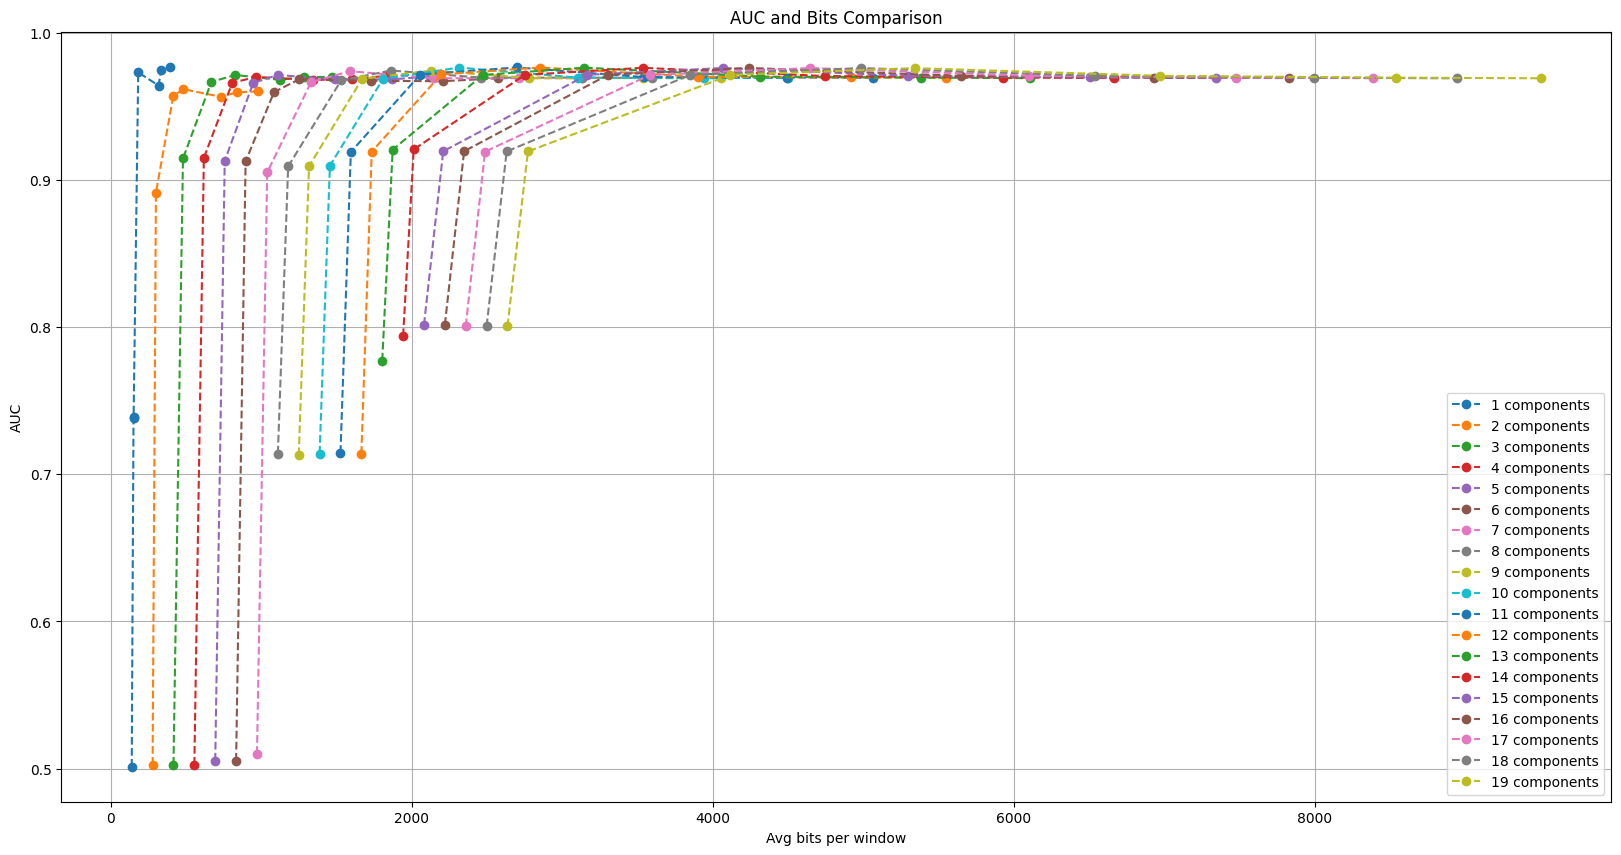

In [22]:
auc_bit = pd.read_csv(os.path.join(base_directory, 'auc_bit_comparison.csv'))
components = [1,2,3,4,5,6,8,10,12,14,16,18]
plt.figure(figsize=(20, 10))
for n_components in auc_bit['n_components'].unique():
    #if (n_components%3 != 0): continue
    #if(n_components not in components): continue
    target_data = auc_bit[auc_bit['n_components'] == n_components]
    plt.plot(target_data['win_bitsENC'], target_data['AUC'], marker='o', linestyle='--', label=f'{n_components} components')
#plt.ylim(0.7)
plt.title('AUC and Bits Comparison')
plt.xlabel('Avg bits per window')
plt.ylabel('AUC')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.savefig(os.path.join(base_directory, 'auc_bit_comparison.png'))
plt.show()

In [ ]:
auc_bit = pd.read_csv(os.path.join(base_directory, 'auc_bit_comparison.csv'))

plt.figure(figsize=(10, 5))
for target in auc_bit['target'].unique():
    target_data = auc_bit[auc_bit['target'] == target]
    plt.plot(target_data['total_bitsREC'], target_data['AUC'], marker='o', linestyle='--', label=f'Target: {target}%')
plt.title('AUC and Bits per Symbol Comparison, Target: ' + str(target) + '%')
plt.xlabel('Total Bits')
plt.ylabel('AUC')
plt.legend()
plt.grid()
#plt.savefig(os.path.join(base_directory, 'auc_bit_comparison.png'))
plt.show()
